<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Arya Jalali
### Student Number : 98105665
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [227]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [228]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [229]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose ([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [231]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [232]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=16, shuffle=True) # Write your code here
val_loader = DataLoader(valid_data, batch_size=16, shuffle=True) # Write your code here

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [238]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ResidualClassifier(nn.Module):
    def __init__(self):
        # same 3 * 3 with RELU conv2d
        super(ResidualClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)

        self.linear1 = nn.Linear(64, 10)

        self.resBlock1 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )

        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)

        self.resBlock2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # global average pooling

        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x + self.resBlock1(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = x + self.resBlock2(x)
        x = self.avgPool(x)
        x = x.view(-1, 64)
        x = self.linear1(x)
        return x

In [239]:
class CamExtension(nn.Module):
    def __init__(self, model: nn.Module):
        super(CamExtension, self).__init__()
        self.model = model
        self.features = None
        self.weights = None

        def save_features(module, input, output):
            self.features = output

        def save_weights(module, input, output):
            self.weights = output

        self.model.resBlock2.register_forward_hook(save_features)
        self.model.avgPool.register_forward_hook(save_weights)

    def forward(self, x):
        x = self.model(x)
        return x

# Train Model (30 Points)

In [240]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
model = CamExtension(model)
# do cross entropy loss
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [241]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []

max_acc = -1


for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0


    for images, labels in tqdm(train_loader):  
        # train the model
        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criteria(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    
    scheduler.step()
    train_loss.append(running_loss/total_step)
    train_acc.append(correct/total)

    print(f'Train epoch: {epoch + 1}, loss: {running_loss / len(train_loader):.5f}, accuracy {train_acc[-1]:.5f}')

    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            # validate the model
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criteria(y_pred, labels)
            running_loss += loss.item()

    if correct/total > max_acc:
        max_acc = correct/total
        torch.save(model.state_dict(), 'model.ckpt')
    val_loss.append(running_loss/total_step)
    val_acc.append(correct/total)

    print(f'Val epoch: {epoch + 1}, loss: {running_loss / len(val_loader):.5f}, accuracy {val_acc[-1]:.5f}')

model.load_state_dict(torch.load('model.ckpt'))

100%|██████████| 3125/3125 [00:30<00:00, 103.10it/s]


Train epoch: 1, loss: 0.32843, accuracy 0.89058


100%|██████████| 625/625 [00:03<00:00, 174.48it/s]


Val epoch: 1, loss: 0.11341, accuracy 0.96690


100%|██████████| 3125/3125 [00:30<00:00, 102.29it/s]


Train epoch: 2, loss: 0.08718, accuracy 0.97336


100%|██████████| 625/625 [00:03<00:00, 180.57it/s]


Val epoch: 2, loss: 0.07674, accuracy 0.97600


100%|██████████| 3125/3125 [00:30<00:00, 102.20it/s]


Train epoch: 3, loss: 0.05950, accuracy 0.98254


100%|██████████| 625/625 [00:03<00:00, 159.89it/s]


Val epoch: 3, loss: 0.05491, accuracy 0.98260


100%|██████████| 3125/3125 [00:30<00:00, 102.18it/s]


Train epoch: 4, loss: 0.04473, accuracy 0.98624


100%|██████████| 625/625 [00:03<00:00, 174.11it/s]


Val epoch: 4, loss: 0.04112, accuracy 0.98640


100%|██████████| 3125/3125 [00:31<00:00, 98.98it/s] 


Train epoch: 5, loss: 0.03643, accuracy 0.98912


100%|██████████| 625/625 [00:04<00:00, 133.14it/s]


Val epoch: 5, loss: 0.04620, accuracy 0.98500


100%|██████████| 3125/3125 [00:33<00:00, 93.75it/s] 


Train epoch: 6, loss: 0.01366, accuracy 0.99576


100%|██████████| 625/625 [00:03<00:00, 158.85it/s]


Val epoch: 6, loss: 0.02244, accuracy 0.99280


100%|██████████| 3125/3125 [00:31<00:00, 98.95it/s] 


Train epoch: 7, loss: 0.01082, accuracy 0.99688


100%|██████████| 625/625 [00:03<00:00, 165.76it/s]


Val epoch: 7, loss: 0.01988, accuracy 0.99250


100%|██████████| 3125/3125 [00:32<00:00, 95.21it/s] 


Train epoch: 8, loss: 0.00914, accuracy 0.99716


100%|██████████| 625/625 [00:03<00:00, 163.42it/s]


Val epoch: 8, loss: 0.02020, accuracy 0.99400


100%|██████████| 3125/3125 [00:31<00:00, 98.92it/s] 


Train epoch: 9, loss: 0.00766, accuracy 0.99780


100%|██████████| 625/625 [00:03<00:00, 172.16it/s]


Val epoch: 9, loss: 0.02181, accuracy 0.99350


100%|██████████| 3125/3125 [00:30<00:00, 102.52it/s]


Train epoch: 10, loss: 0.00663, accuracy 0.99822


100%|██████████| 625/625 [00:03<00:00, 166.75it/s]


Val epoch: 10, loss: 0.02026, accuracy 0.99310


100%|██████████| 3125/3125 [00:30<00:00, 102.21it/s]


Train epoch: 11, loss: 0.00446, accuracy 0.99894


100%|██████████| 625/625 [00:03<00:00, 171.97it/s]


Val epoch: 11, loss: 0.01969, accuracy 0.99360


100%|██████████| 3125/3125 [00:29<00:00, 104.28it/s]


Train epoch: 12, loss: 0.00419, accuracy 0.99900


100%|██████████| 625/625 [00:03<00:00, 176.72it/s]


Val epoch: 12, loss: 0.01981, accuracy 0.99380


100%|██████████| 3125/3125 [00:30<00:00, 102.28it/s]


Train epoch: 13, loss: 0.00406, accuracy 0.99910


100%|██████████| 625/625 [00:03<00:00, 170.37it/s]


Val epoch: 13, loss: 0.01997, accuracy 0.99350


100%|██████████| 3125/3125 [00:30<00:00, 101.53it/s]


Train epoch: 14, loss: 0.00393, accuracy 0.99914


100%|██████████| 625/625 [00:03<00:00, 169.76it/s]


Val epoch: 14, loss: 0.02023, accuracy 0.99370


100%|██████████| 3125/3125 [00:30<00:00, 102.51it/s]


Train epoch: 15, loss: 0.00380, accuracy 0.99916


100%|██████████| 625/625 [00:03<00:00, 170.49it/s]


Val epoch: 15, loss: 0.02041, accuracy 0.99380


100%|██████████| 3125/3125 [00:31<00:00, 100.17it/s]


Train epoch: 16, loss: 0.00361, accuracy 0.99916


100%|██████████| 625/625 [00:03<00:00, 170.34it/s]


Val epoch: 16, loss: 0.02039, accuracy 0.99380


100%|██████████| 3125/3125 [00:32<00:00, 95.38it/s] 


Train epoch: 17, loss: 0.00358, accuracy 0.99918


100%|██████████| 625/625 [00:03<00:00, 171.42it/s]


Val epoch: 17, loss: 0.02036, accuracy 0.99380


100%|██████████| 3125/3125 [00:30<00:00, 100.98it/s]


Train epoch: 18, loss: 0.00356, accuracy 0.99920


100%|██████████| 625/625 [00:03<00:00, 171.72it/s]


Val epoch: 18, loss: 0.02036, accuracy 0.99390


100%|██████████| 3125/3125 [00:30<00:00, 101.43it/s]


Train epoch: 19, loss: 0.00354, accuracy 0.99918


100%|██████████| 625/625 [00:03<00:00, 159.33it/s]


Val epoch: 19, loss: 0.02037, accuracy 0.99390


100%|██████████| 3125/3125 [00:31<00:00, 100.44it/s]


Train epoch: 20, loss: 0.00353, accuracy 0.99920


100%|██████████| 625/625 [00:03<00:00, 164.29it/s]

Val epoch: 20, loss: 0.02037, accuracy 0.99390


<All keys matched successfully>

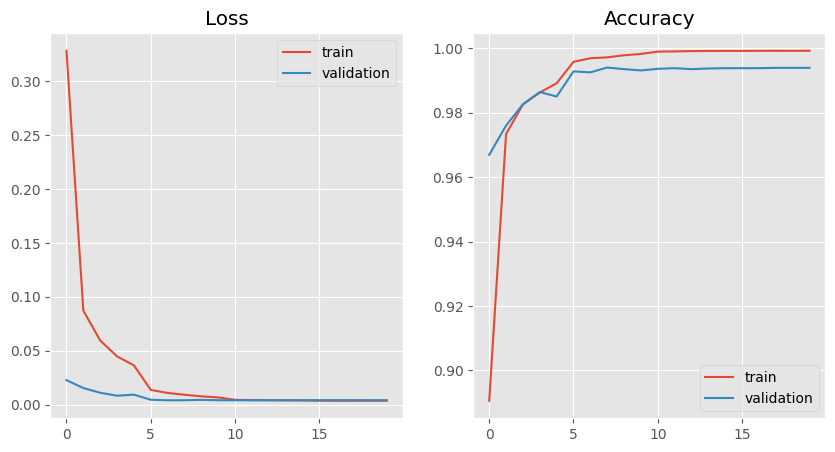

In [242]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################


# plot loss and accuracy for train and validation sets

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.legend()

plt.show()

# Test Model (20 Points)

10000
Test Accuracy of the model on the 10000 test images: 99.37 %
10000


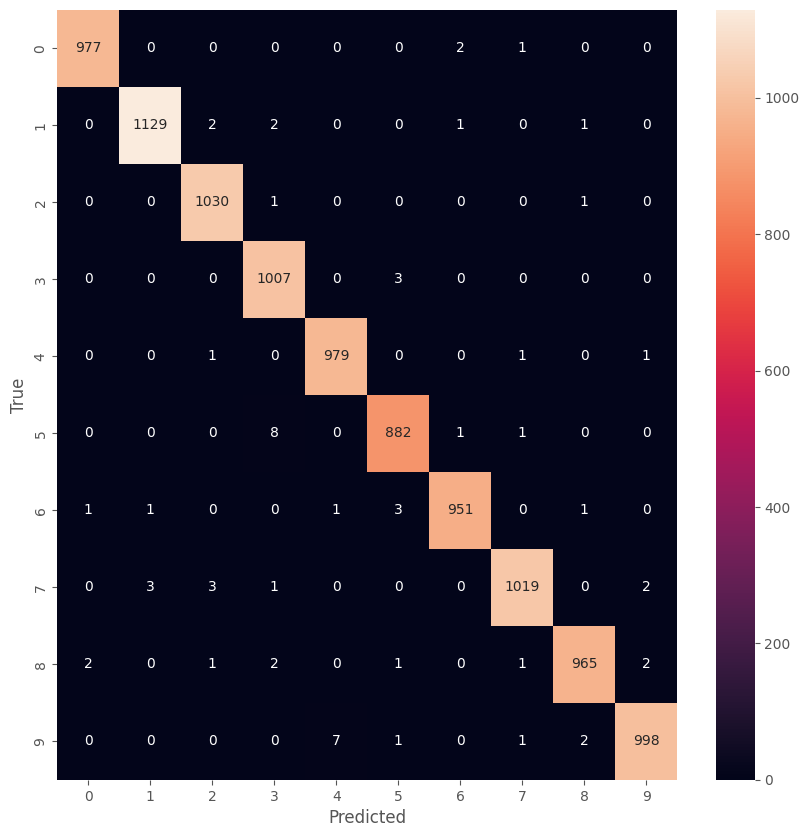

In [244]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

correct = 0
total = 0

tot_labels = torch.tensor([]).to(device)
tot_predicted = torch.tensor([]).to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images)
        _, predicted = torch.max(y_pred.data, 1)

        tot_labels = torch.cat((tot_labels, labels))
        tot_predicted = torch.cat((tot_predicted, predicted))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
print(total)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(tot_labels.cpu(), tot_predicted.cpu())
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# CAM for model interpretability

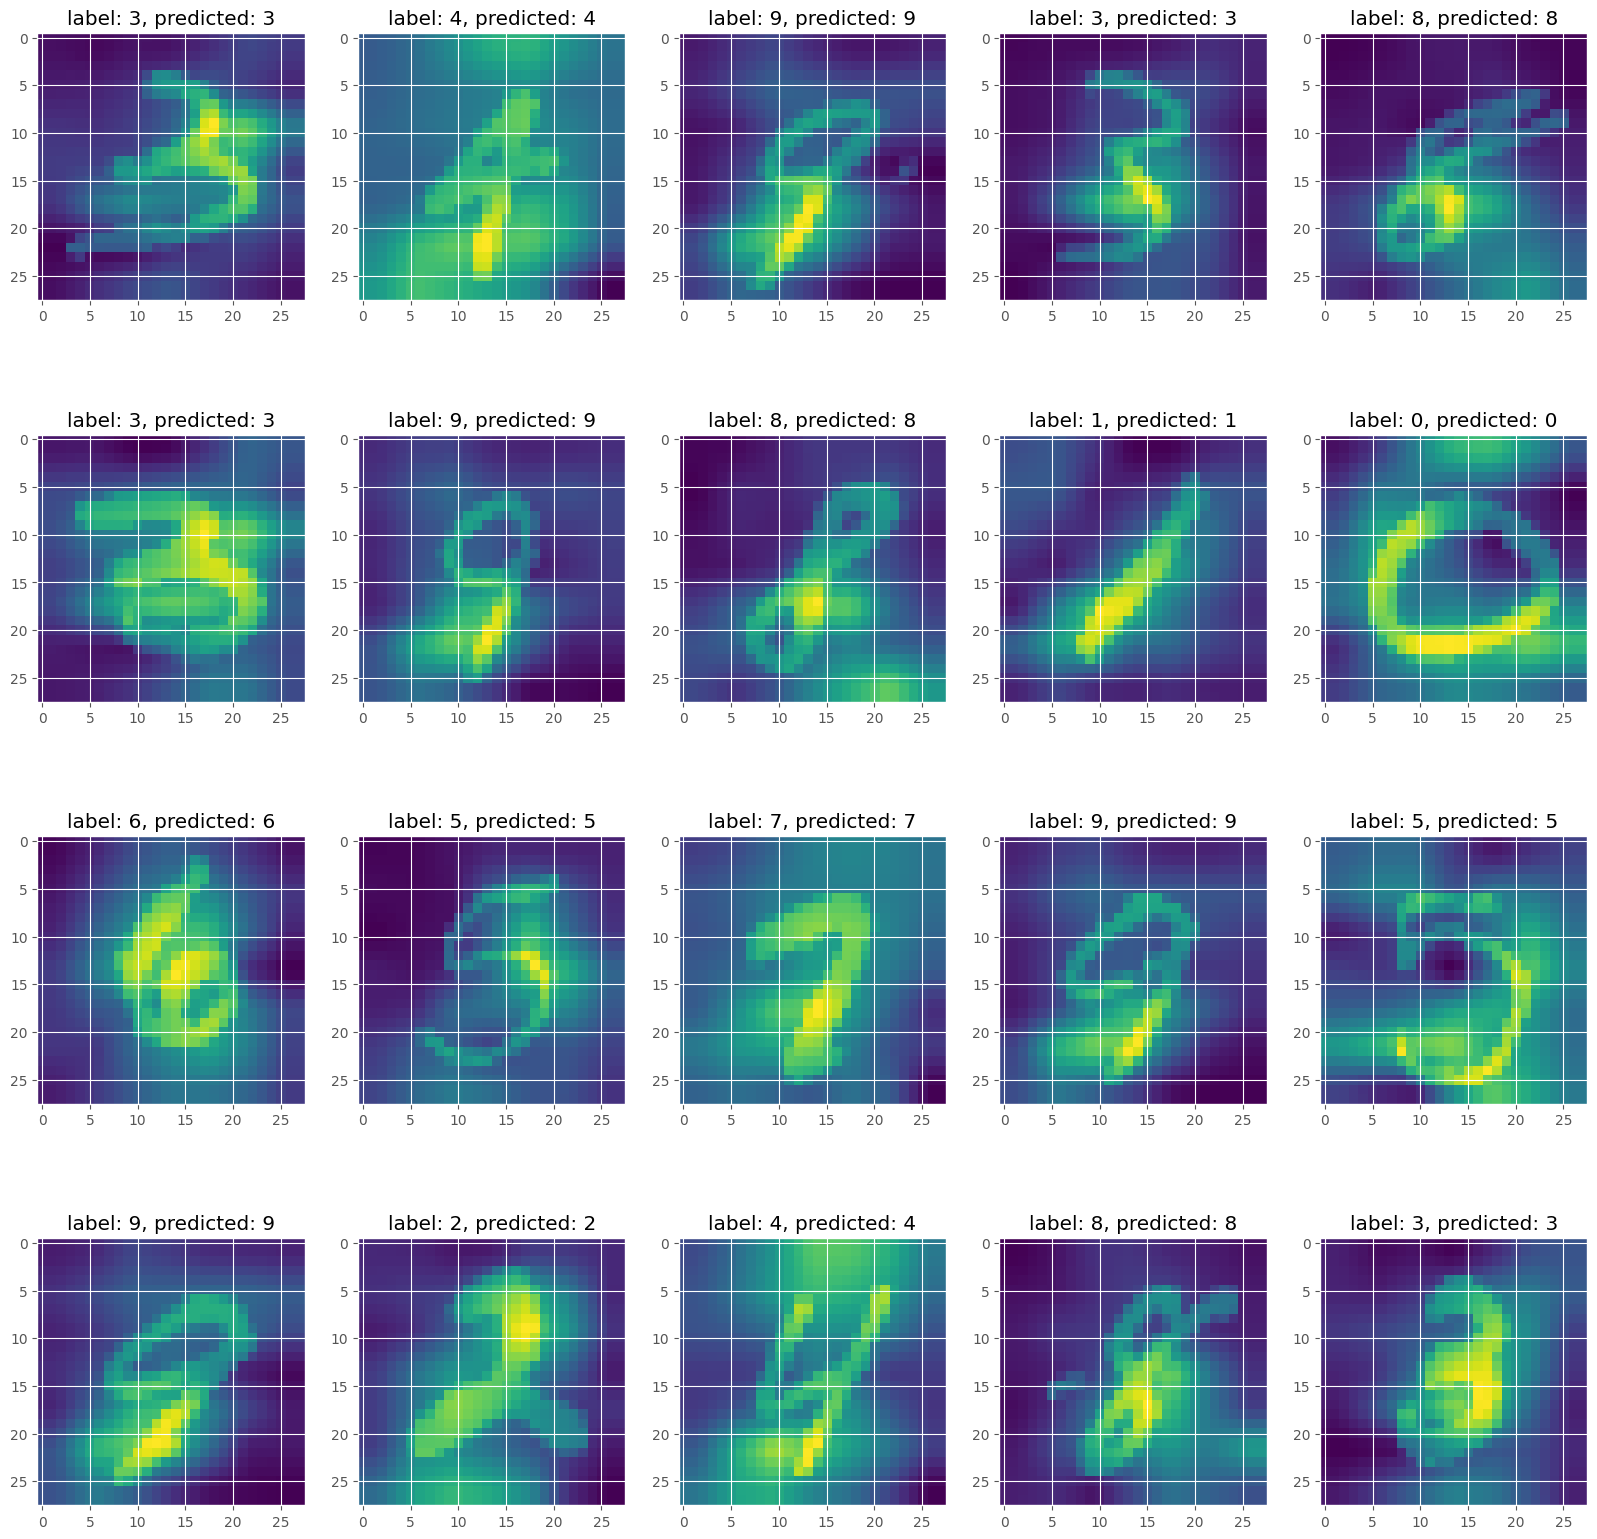

In [253]:
import cv2

fig = plt.figure(figsize=(20, 20))
for i in range(20):
    idx = np.random.randint(0, len(test_data))
    first_image = test_loader.dataset[idx][0]
    plt.subplot(4, 5, i+1)
    plt.title(f'label: {test_loader.dataset[idx][1]}, predicted: {model(first_image.unsqueeze(0).to(device)).argmax().item()}')
    model(first_image.unsqueeze(0).to(device))
    first_image = first_image.permute(1, 2, 0)
    params = model.model.linear1.weight[test_loader.dataset[idx][1]]
    cam = torch.zeros(1, 1, 7, 7).to(device)
    for i in range(len(params)):
        cam += params[i] * model.features[0][i]
    cam = cam[0,0].cpu().detach().numpy()
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (28, 28)) / 255
    alpha = 0.90
    cam = alpha * cam + (1 - alpha) * np.float32(first_image.squeeze())
    cam = cam / np.max(cam)
    plt.imshow(cam)
